# DeepFool ATTACK

In [1]:
# !pip install facenet-pytorch
# !pip install Pillow
# !pip install -q tensorflow==2.0.0
# !pip install adversarial-robustness-toolbox[all]
# !pip install matplotlib

### *Import*



### initialization

In [2]:
import os
import re
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from torchvision import transforms
import torch
from torch.nn import CrossEntropyLoss
import torch.nn as nn
from art.estimators.classification import PyTorchClassifier
import tensorflow as tf
from matplotlib import pyplot as plt
# Import all L-distance based attacks
from art.attacks.evasion import CarliniL2Method, CarliniL0Method, CarliniLInfMethod
from utils import load_test_image_NN2_preprocessed

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = str(device)
print(device)

cuda


In [3]:
if device in 'cuda':
    print("Import Inception.Inception")
    import inception
    nn1 = inception.InceptionResnetV1(pretrained='vggface2').eval()
    nn1 .classify = True
elif device == "cpu":
    print("Import Facenet.Inception")
    from facenet_pytorch import InceptionResnetV1
    nn1  = InceptionResnetV1(pretrained='vggface2').eval()
    nn1.classify = True

nn1.to(device)

model_nn1 = PyTorchClassifier(nn1,input_shape=[160,160], loss=CrossEntropyLoss(),nb_classes=8631, device_type=device) #This class implements a classifier with the PyTorch framework.


Import Inception.Inception


In [4]:
from RESNET import ResNet
from utils import get_labels
from utils import load_state_dict

nn2 = ResNet.resnet50(num_classes=8631, include_top=True)


load_state_dict(nn2,'resnet50_scratch_weight.pkl')
nn2.eval()

model_nn2 = PyTorchClassifier(nn2,input_shape=[224,224], loss=CrossEntropyLoss(),nb_classes=8631, device_type=device)

LABELS = get_labels()

### Untargeted Attack on all test set

In [5]:
from art.attacks.evasion import DeepFool
import os
import re
import numpy as np
from utils import load_image_NN1, load_test_image_NN2

dataset_dir = "test_set_cropped/"
#eps_step = [0.001, 0.02 ,0.05, 0.07, 0.3, 0.5, 0.7, 1]
#eps_step = [0.00001, 0.0001, 0.001, 0.003, 0.005, 0.007, 0.01, 0.05, 0.07, 0.1, 0.7, 1, 2]
#eps_step = [1e-20, 1e-15, 1e-10, 1]
eps_step =[0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6, 0.7, 0.8, 0.9]
max_iter = [1,5]


accuracy_for_eps_nn1 = np.zeros((len(max_iter),len(eps_step)))
perturbation_for_eps_nn1 = np.zeros((len(max_iter),len(eps_step)))
correct_predictions_nn1 = 0

accuracy_for_eps_nn2 = np.zeros((len(max_iter),len(eps_step)))
perturbation_for_eps_nn2 = np.zeros((len(max_iter),len(eps_step)))
correct_predictions_nn2 = 0

accuracy_for_eps_nn2_preprocessed=np.zeros((len(max_iter),len(eps_step)))
correct_predictions_nn2_preprocessed=0


total_images = 0
print("Inizio Attacco DeepFool NON-TARGETED")

# Ensure models and labels are defined and loaded
# model_nn1, model_nn2, LABELS should be defined here
for i in range(len(max_iter)):
    for j in range(len(eps_step)):
        correct_predictions_nn1 = 0
        correct_predictions_nn2 = 0
        correct_predictions_nn2_preprocessed=0
        total_images = 0

        perturbations = []
        attack = DeepFool(classifier=model_nn1, epsilon=eps_step[j], max_iter=max_iter[i])

        print(f"**** Attacco con eps: {eps_step[j]} ****")
        for filename in os.listdir(dataset_dir):
            if filename.endswith(".jpg") or filename.endswith(".jpeg"):
                person_path = os.path.join(dataset_dir, filename)
                test_img = load_image_NN1(person_path, device).numpy()
                test_images_adv = attack.generate(test_img)
                nn1_predictions = model_nn1.predict(test_images_adv)
                test_images_NN2 = load_test_image_NN2(test_images_adv)
                nn2_predictions = model_nn2.predict(test_images_NN2)

                test_images_NN2_preprocessed= load_test_image_NN2_preprocessed(test_images_adv)
                nn2_prediction_preprocessed=model_nn2.predict(test_images_NN2_preprocessed)

                correct_label = re.sub(r'_\d+_face_0\.jpg$', '', filename)
                perturbations.append(np.linalg.norm(test_images_adv - test_img))

                predicted_label_nn1 = LABELS[np.array(nn1_predictions.argmax())]
                predicted_label_nn2 = LABELS[np.array(nn2_predictions.argmax())]
                predicted_label_nn2_preprocessed= LABELS[np.array(nn2_prediction_preprocessed.argmax())]

                total_images += 1

                if correct_label in predicted_label_nn1:
                    correct_predictions_nn1 += 1

                if correct_label in predicted_label_nn2:
                    correct_predictions_nn2 += 1

                if correct_label in predicted_label_nn2_preprocessed:
                    correct_predictions_nn2_preprocessed +=1

        if total_images != 0:
            perturbation_mean = np.mean(perturbations)
            perturbation_for_eps_nn1[i][j]=perturbation_mean
        
            accuracy_nn1 = correct_predictions_nn1 / total_images
            accuracy_for_eps_nn1[i][j]=accuracy_nn1

            accuracy_nn2 = correct_predictions_nn2/ total_images
            accuracy_for_eps_nn2[i][j]=accuracy_nn2

            accuracy_nn2_preprocessed= correct_predictions_nn2_preprocessed/total_images
            accuracy_for_eps_nn2_preprocessed[i][j]=accuracy_nn2_preprocessed

            print(f"Accuracy Inception ResNet for eps {eps_step[j]}: {accuracy_nn1}")
            print(f"Accuracy Resnet50 for eps {eps_step[j]}: {accuracy_nn2}")
            print(f"Average perturbation for eps {eps_step[j]}: {perturbation_mean}")


Inizio Attacco DeepFool NON-TARGETED
**** Attacco con eps: 0.05 ****


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

c:\Users\beatr\anaconda3\envs\envai4cyber\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy Inception ResNet for eps 0.05: 0.174
Accuracy Resnet50 for eps 0.05: 0.856
Average perturbation for eps 0.05: 0.0016714653465896845
**** Attacco con eps: 0.1 ****


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy Inception ResNet for eps 0.1: 0.161
Accuracy Resnet50 for eps 0.1: 0.856
Average perturbation for eps 0.1: 0.0017510595498606563
**** Attacco con eps: 0.15 ****


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy Inception ResNet for eps 0.15: 0.153
Accuracy Resnet50 for eps 0.15: 0.852
Average perturbation for eps 0.15: 0.001830653171055019
**** Attacco con eps: 0.2 ****


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy Inception ResNet for eps 0.2: 0.142
Accuracy Resnet50 for eps 0.2: 0.851
Average perturbation for eps 0.2: 0.0019102470250800252
**** Attacco con eps: 0.25 ****


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy Inception ResNet for eps 0.25: 0.124
Accuracy Resnet50 for eps 0.25: 0.846
Average perturbation for eps 0.25: 0.001989840529859066
**** Attacco con eps: 0.3 ****


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy Inception ResNet for eps 0.3: 0.11
Accuracy Resnet50 for eps 0.3: 0.846
Average perturbation for eps 0.3: 0.0020694336853921413
**** Attacco con eps: 0.35 ****


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy Inception ResNet for eps 0.35: 0.105
Accuracy Resnet50 for eps 0.35: 0.84
Average perturbation for eps 0.35: 0.0021490277722477913
**** Attacco con eps: 0.4 ****


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy Inception ResNet for eps 0.4: 0.095
Accuracy Resnet50 for eps 0.4: 0.836
Average perturbation for eps 0.4: 0.0022286209277808666
**** Attacco con eps: 0.45 ****


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy Inception ResNet for eps 0.45: 0.083
Accuracy Resnet50 for eps 0.45: 0.831
Average perturbation for eps 0.45: 0.0023082152474671602
**** Attacco con eps: 0.5 ****


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy Inception ResNet for eps 0.5: 0.074
Accuracy Resnet50 for eps 0.5: 0.828
Average perturbation for eps 0.5: 0.002387808868661523
**** Attacco con eps: 0.6 ****


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy Inception ResNet for eps 0.6: 0.064
Accuracy Resnet50 for eps 0.6: 0.818
Average perturbation for eps 0.6: 0.002546995645388961
**** Attacco con eps: 0.7 ****


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy Inception ResNet for eps 0.7: 0.056
Accuracy Resnet50 for eps 0.7: 0.807
Average perturbation for eps 0.7: 0.0027061831206083298
**** Attacco con eps: 0.8 ****


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy Inception ResNet for eps 0.8: 0.048
Accuracy Resnet50 for eps 0.8: 0.796
Average perturbation for eps 0.8: 0.002865370362997055
**** Attacco con eps: 0.9 ****


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy Inception ResNet for eps 0.9: 0.043
Accuracy Resnet50 for eps 0.9: 0.784
Average perturbation for eps 0.9: 0.0030245576053857803
**** Attacco con eps: 0.05 ****


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy Inception ResNet for eps 0.05: 0.021
Accuracy Resnet50 for eps 0.05: 0.852
Average perturbation for eps 0.05: 0.0019298645202070475
**** Attacco con eps: 0.1 ****


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy Inception ResNet for eps 0.1: 0.021
Accuracy Resnet50 for eps 0.1: 0.852
Average perturbation for eps 0.1: 0.0020245308987796307
**** Attacco con eps: 0.15 ****


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy Inception ResNet for eps 0.15: 0.019
Accuracy Resnet50 for eps 0.15: 0.848
Average perturbation for eps 0.15: 0.00211365451104939
**** Attacco con eps: 0.2 ****


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy Inception ResNet for eps 0.2: 0.019
Accuracy Resnet50 for eps 0.2: 0.847
Average perturbation for eps 0.2: 0.0022054524160921574
**** Attacco con eps: 0.25 ****


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy Inception ResNet for eps 0.25: 0.016
Accuracy Resnet50 for eps 0.25: 0.843
Average perturbation for eps 0.25: 0.0022973704617470503
**** Attacco con eps: 0.3 ****


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy Inception ResNet for eps 0.3: 0.016
Accuracy Resnet50 for eps 0.3: 0.843
Average perturbation for eps 0.3: 0.0023927257861942053
**** Attacco con eps: 0.35 ****


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy Inception ResNet for eps 0.35: 0.015
Accuracy Resnet50 for eps 0.35: 0.835
Average perturbation for eps 0.35: 0.002484808675944805
**** Attacco con eps: 0.4 ****


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy Inception ResNet for eps 0.4: 0.015
Accuracy Resnet50 for eps 0.4: 0.831
Average perturbation for eps 0.4: 0.0025733120273798704
**** Attacco con eps: 0.45 ****


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy Inception ResNet for eps 0.45: 0.014
Accuracy Resnet50 for eps 0.45: 0.827
Average perturbation for eps 0.45: 0.0026642854791134596
**** Attacco con eps: 0.5 ****


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy Inception ResNet for eps 0.5: 0.014
Accuracy Resnet50 for eps 0.5: 0.824
Average perturbation for eps 0.5: 0.0027567530050873756
**** Attacco con eps: 0.6 ****


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy Inception ResNet for eps 0.6: 0.011
Accuracy Resnet50 for eps 0.6: 0.814
Average perturbation for eps 0.6: 0.0029405923560261726
**** Attacco con eps: 0.7 ****


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy Inception ResNet for eps 0.7: 0.01
Accuracy Resnet50 for eps 0.7: 0.801
Average perturbation for eps 0.7: 0.003124358132481575
**** Attacco con eps: 0.8 ****


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy Inception ResNet for eps 0.8: 0.01
Accuracy Resnet50 for eps 0.8: 0.789
Average perturbation for eps 0.8: 0.0033085159957408905
**** Attacco con eps: 0.9 ****


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

Accuracy Inception ResNet for eps 0.9: 0.01
Accuracy Resnet50 for eps 0.9: 0.778
Average perturbation for eps 0.9: 0.003496105782687664


In [6]:
print(eps_step)

print(accuracy_for_eps_nn1)
print("\n")
print(accuracy_for_eps_nn2)
print("\n")
print(accuracy_for_eps_nn2_preprocessed)

[0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6, 0.7, 0.8, 0.9]
[[0.174 0.161 0.153 0.142 0.124 0.11  0.105 0.095 0.083 0.074 0.064 0.056
  0.048 0.043]
 [0.021 0.021 0.019 0.019 0.016 0.016 0.015 0.015 0.014 0.014 0.011 0.01
  0.01  0.01 ]]


[[0.856 0.856 0.852 0.851 0.846 0.846 0.84  0.836 0.831 0.828 0.818 0.807
  0.796 0.784]
 [0.852 0.852 0.848 0.847 0.843 0.843 0.835 0.831 0.827 0.824 0.814 0.801
  0.789 0.778]]


[[0.902 0.901 0.899 0.897 0.895 0.895 0.894 0.892 0.892 0.888 0.884 0.879
  0.872 0.864]
 [0.901 0.901 0.899 0.897 0.895 0.895 0.894 0.892 0.892 0.888 0.884 0.879
  0.871 0.863]]


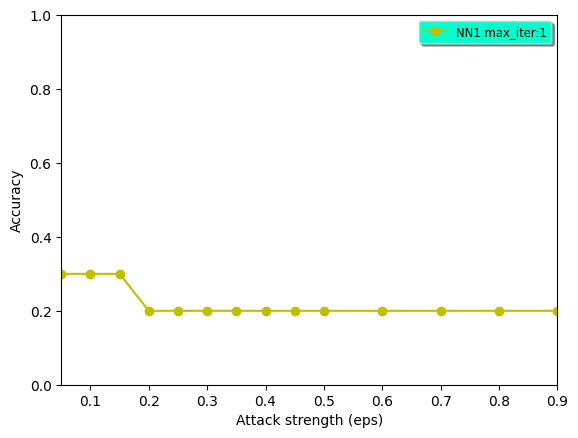

In [37]:
from matplotlib import pyplot as plt

# plot accuracy/Attack strength NN1-NN2

fig, ax = plt.subplots()

ax.plot(np.array(eps_step), np.array(accuracy_for_eps_nn1[0]), 'y--', label='NN1 max_iter:{}'.format(max_iter[0]))
ax.plot(np.array(eps_step), np.array(accuracy_for_eps_nn1[1]), 'r--', label='NN1 max_iter:{}'.format(max_iter[1]))
ax.plot(np.array(eps_step), np.array(accuracy_for_eps_nn2[0]), 'g--', label='NN2 max_iter:{}'.format(max_iter[0]))
ax.plot(np.array(eps_step), np.array(accuracy_for_eps_nn2[1]), 'm--', label='NN2 max_iter:{}'.format(max_iter[1]))

legend = ax.legend(loc='upper right', shadow=True, fontsize='small')
legend.get_frame().set_facecolor('#00FFCC')

ax.set_xlim(eps_step[0], eps_step[-1])  # Imposta i limiti dell'asse x
ax.set_ylim(0,1)  # Imposta i limiti dell'asse y
plt.xlabel('Attack strength (eps)')
plt.ylabel('Accuracy')
plt.show()

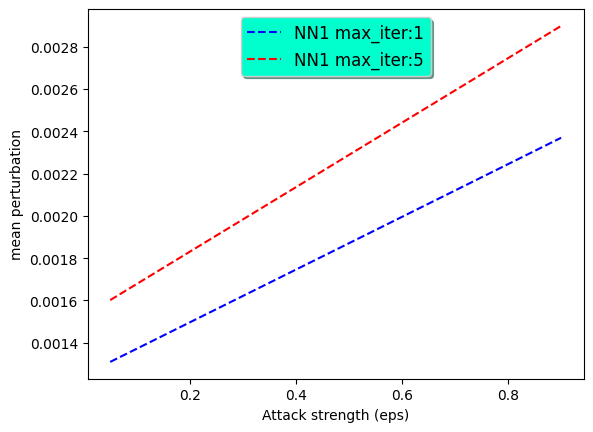

In [19]:
fig, ax = plt.subplots()
ax.plot(np.array(eps_step), np.array(perturbation_for_eps_nn1[0]), 'b--', label='NN1 max_iter:{}'.format(max_iter[0]))
ax.plot(np.array(eps_step), np.array(perturbation_for_eps_nn1[1]), 'r--', label='NN1 max_iter:{}'.format(max_iter[1]))
legend = ax.legend(loc='upper center', shadow=True, fontsize='large')
legend.get_frame().set_facecolor('#00FFCC')

plt.xlabel('Attack strength (eps)')
plt.ylabel('mean perturbation')
plt.show()

### Single sample Untargeted attack

In [ ]:
from art.attacks.evasion import DeepFool

epsilon =0.09
max_iter = 5

attack = DeepFool(classifier=model_nn1, epsilon=epsilon, max_iter=max_iter)

In [ ]:
from utils import load_image_NN1
dataset_dir = "test_set_cropped/"
filename = "Ursula_von_der_Leyen_6_face_0.jpg"

person_path = os.path.join(dataset_dir, filename)
test_img = load_image_NN1(person_path,device)
test_img_numpy = test_img.numpy()
test_images_adv = attack.generate(test_img_numpy)

nn1_predictions = model_nn1.predict(test_images_adv)
perturbation = np.mean(np.abs((test_images_adv - test_img_numpy)))
print('Average perturbation: {:4.2f}'.format(perturbation))


test_images_NN2 = load_test_image_NN2_preprocessed(test_images_adv)
nn2_predictions = model_nn2.predict(test_images_NN2)



predicted_label_nn1= LABELS[np.array(nn1_predictions.argmax())]
predicted_label_nn2 = LABELS[np.array(nn2_predictions.argmax())]
print("NN1{} con probabilità {}".format(predicted_label_nn1,nn1_predictions[0][nn1_predictions.argmax()]))
print("NN2{} con probabilità {}".format(predicted_label_nn2,nn2_predictions[0][nn2_predictions.argmax()]))


In [ ]:
# Prepara le immagini per la visualizzazione
# Rimuovi la dimensione batch extra e converti nel formato channels-last
test_images_adv = np.squeeze(test_images_adv, axis=0)
test_images_adv = np.transpose(test_images_adv, (1, 2, 0))

# Converti le immagini in uint8 per la visualizzazione
if test_img_numpy.dtype != np.uint8:
    test_img_numpy = (test_img_numpy * 255).astype(np.uint8)
    test_img_numpy = np.squeeze(test_img_numpy, axis=0)  # Rimuovi la dimensione batch extra
    test_img_numpy = np.transpose(test_img_numpy, (1, 2, 0))

if test_images_adv.dtype != np.uint8:
    test_images_adv = (test_images_adv * 255).astype(np.uint8)

# Visualizza le immagini affiancate con Matplotlib
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Mostra l'immagine originale
ax1.imshow(test_img_numpy)
ax1.set_title('Original Image')
ax1.axis('off')

# Mostra l'immagine avversaria
ax2.imshow(test_images_adv)
ax2.set_title(f'Adversarial Image\nPredicted: {predicted_label_nn1}')
ax2.axis('off')

# Mostra la figura
plt.suptitle("DeepFool Adversarial Images")
plt.show()
